# Install packages

In [ ]:
#----install stuff
!pip install mlxtend
!pip install -U imbalanced-learn
!python ../../software/python-glmnet/setup.py
!conda install -c conda-forge tensorflow
!conda install -c conda-forge keras

# Import

In [136]:
from __init__ import *
from funcs_model import *
from matplotlib import pyplot as plt
from matplotlib import style as pltstyle
pltstyle.use("ggplot")

# Feature transformers

In [3]:
def transform_features(X):
    # feature transformation: take sqrt of count data
    for e in X.filter(regex=('count$')).columns: X[e] = np.sqrt(X[e] )
    return X

# Classification pipeline

In [93]:
#--------classification pipe
#clf2=LogitNet(fit_intercept=True,alpha=0,n_splits=3,n_jobs=1, scoring=score_custom_precision)
fsel=RFECV(LogisticRegression(),step=1, cv=TimeSeriesSplit(n_splits=2), scoring="log_loss", verbose=0, n_jobs=1)
pipe=ImbPipe([
            ('ft', FunctionTransformer(transform_features,validate=False)),
            ('rs', RobustScaler()), 
            #('fs', fsel), 
            #('pca',PCA(n_components=10)),
            #('sm', sm), 
            ('clf1',LogisticRegression(fit_intercept=True,C=0.001,class_weight='balanced'))
            ])
params = {
          'clf1__C': [0.001,0.0025,0.005,0.0075,0.01,0.025,0.05],
            'clf1__penalty': ['l1']
         }
grid1 = GridSearchCV(estimator=pipe,refit=True,param_grid=params,n_jobs=8,verbose=0,
                    cv=TimeSeriesSplit(n_splits=2,max_train_size=80000),
                    scoring="log_loss")
grid2 = GridSearchCV(estimator=pipe,refit=True,param_grid=params,n_jobs=8,verbose=0,
                    cv=TimeSeriesSplit(n_splits=2,max_train_size=80000),
                    scoring=score_custom_precision)

# Data prep

In [5]:
# -------load data
data=pd.read_csv("training_data/bitfinex_btcusd.csv.gz")
DAYS=ma.ceil((data.timstamp[-1:] - data.timstamp[1])/3600/24)
print('............shape dataset:', data.shape)
print('............days in datase:', DAYS)

............shape dataset: (1665559, 35)
............days in datase: 64


In [6]:
def prep_data(data,col_target,col_price,vector_time,P):
    d=data.copy()
    d['timstamp'] = d[vector_time]
    d['price_real'] = d[col_price]
    d['target'] = d[col_target]
    if P['DIRECTION'] == "short": d['target'] = -1 * d['target'] 
    d['target_cat'] = np.where(d['target'] >= P['THRES_PROF'], 1,0)
    d=d.dropna(subset=[P['FEATURES'] + [col_target,'target','target_cat']])
    return d

# Run best model

In [94]:
#--------------BACKTESTING
PARAS = OrderedDict(
    TYPE="classify",
    DIRECTION = 'long',
    THRES_PROF = 0.004081,
    TARGET_TIME = 300,
    TRAIN_THRES=0.005,
    N_TRAIN = 100000,
    N_TRAIN_MIN = 100000,
    N_WINDOW_MIN = 100000,
    TRAIN_STRATEGY = "NONE",
    MODEL=grid1,
    BACKTEST_SPLITS=64,
    FEATURES = data.filter(regex=('width$|^(imba)|^(adj)|^(tr)|^(t[0-9])|^(agg)|(mid$)')).columns.tolist(),
    FEE_BUY=0.002,
    FEE_SELL=0.002,
    MODEL_SCORER=None
)

d=prep_data(data,col_target='mid' + str(PARAS['TARGET_TIME']),col_price='mid',vector_time='timstamp',P=PARAS)
test=backtesting(d,PARAS)

from_i: 102949 to_i: 109808 targets_total: 6742 targets_prop 0.0699464663651
{'clf1__C': 0.0025, 'clf1__penalty': 'l1'} 0.113669450651
from_i: 109809 to_i: 116668 targets_total: 6793 targets_prop 0.0703974299186
{'clf1__C': 0.005, 'clf1__penalty': 'l1'} 0.112973387359
from_i: 116669 to_i: 123528 targets_total: 6243 targets_prop 0.0645571583682
{'clf1__C': 0.001, 'clf1__penalty': 'l1'} 0.107971257407
from_i: 123529 to_i: 130388 targets_total: 5243 targets_prop 0.0540370622307
{'clf1__C': 0.0025, 'clf1__penalty': 'l1'} 0.130392449278
from_i: 130389 to_i: 137248 targets_total: 6209 targets_prop 0.0639141086612
{'clf1__C': 0.01, 'clf1__penalty': 'l1'} 0.237095830762
from_i: 137249 to_i: 144108 targets_total: 6308 targets_prop 0.0649800156578
{'clf1__C': 0.025, 'clf1__penalty': 'l1'} 0.246760858358
from_i: 144109 to_i: 150968 targets_total: 5965 targets_prop 0.0613468539811
{'clf1__C': 0.01, 'clf1__penalty': 'l1'} 0.0874182301208
from_i: 150969 to_i: 157828 targets_total: 5930 targets_prop 

# Evaluate model

        ROI  ROI_bench   ROI_day  trades       days  max_trades  days_trading  \
0  1.538826   0.791742  0.025012      94  61.523555       48495            18   

   cutoff  precision      TYPE     ...      TRAIN_THRES  N_TRAIN  N_TRAIN_MIN  \
0    0.97   0.622995  classify     ...            0.005   100000       100000   

   N_WINDOW_MIN  TRAIN_STRATEGY  BACKTEST_SPLITS  \
0        100000            NONE               64   

                                            FEATURES FEE_BUY  FEE_SELL  \
0  [width, mid, imbalance2, adj_price2, imbalance...   0.002     0.002   

  MODEL_SCORER  
0         None  

[1 rows x 23 columns]


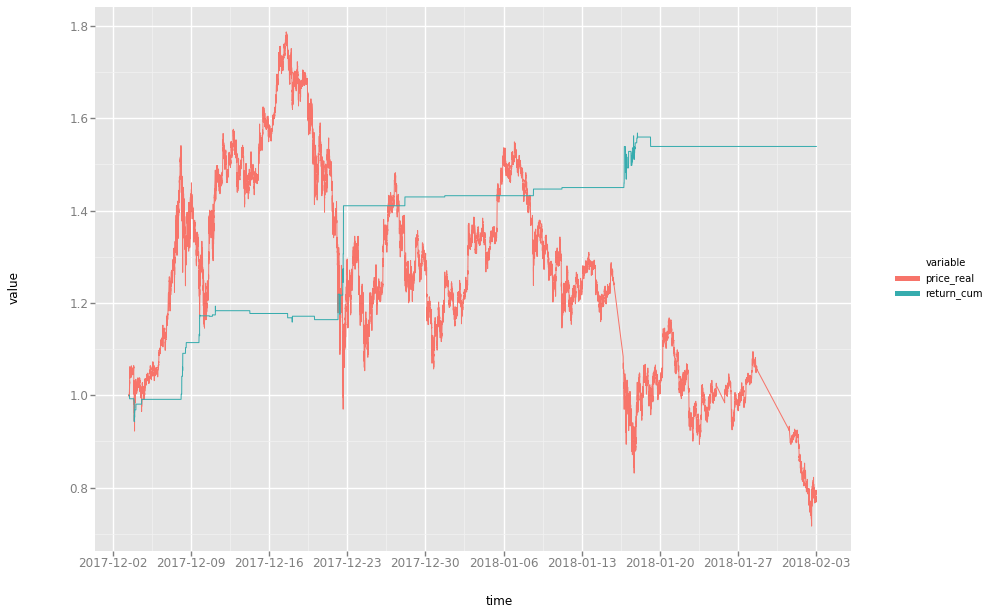

<ggplot: (-9223363276209041962)>

In [151]:
PARAS['FEE_BUY']=0.002
PARAS['FEE_SELL']=0.002
cutoff=list(np.arange(0.9,0.99,0.01))
kpi_obj=eval_model(test,cutoff,PARAS)
kpi = kpi_obj['data']
print(kpi_obj['kpis'])
from ggplot import *
data_plot=pd.melt(kpi[['return_cum','price_real','time']], id_vars=['time'])
p = ggplot(data_plot, aes(x='time', y='value', color='variable')) + geom_line() 
t = theme_gray()
t._rcParams['figure.figsize'] = '15,10' 
p + t

# Find best model

In [9]:
'''
result=[]
runner=pd.DataFrame(expandgrid(
                ['long'],
                [0.004081],
                [pipe],
                [100000,150000],
                [0.0042,0.006,0.007,0.008,0.009,0.01,0.012,0.014,0.016,0.018,0.02,0.022,0.024,0.026],
                #[0.013,0.014,0.015],
                [300,60,900]
))
runner.columns = ['DIRECTION','THRES_PROF','MODEL','N_TRAIN','TRAIN_THRES','TARGET_TIME']

print('brute force runs: ' + str(len(runner)))

for i in np.arange(0,runner.shape[0]):
    print('#----------------' + str(i))
    with open('log_backtest.txt', 'a') as f: f.write('#----------------' + str(i) + ' of ' +str(runner.shape[0]) )
    DIRECTION = runner.loc[i,'DIRECTION']
    THRES_PROF = runner.loc[i,'THRES_PROF']
    TARGET_TIME = runner.loc[i,'TARGET_TIME']
    TRAIN_THRES = runner.loc[i,'TRAIN_THRES']
    N_TRAIN = runner.loc[i,'N_TRAIN']
    N_TRAIN_MIN = 150000
    SKIP_TRADE=TARGET_TIME
    FEE_BUY=0.002
    FEE_SELL=0.002
    TYPE="classify"
    TRAIN_STRATEGY = "NONE"
    MODEL=runner.loc[i,'MODEL']
    BACKTEST_SPLITS=10
    d=prep_data(data,col_target='mid' + str(TARGET_TIME),col_price='mid')
    FEATURES = d.filter(regex=('width$|^(imba)|^(adj)|^(tr)|^(t[0-9])|^(agg)|(mid$)')).columns
    gc.collect()
    try:
        test=backtesting(d)
        r=eval_model(test,-999)['kpis']
        result.append(r)
        pd.concat(result).sort_values("ROI",ascending=False).to_csv('models_brute.csv')
    except Exception as e: 
        print(e)
        with open('log_backtest.txt', 'a') as f: f.write('#----------------' + str(i) + str(e))

pd.concat(result).sort_values('ROI',ascending=False).head(3)
'''

'\nresult=[]\nrunner=pd.DataFrame(expandgrid(\n                [\'long\'],\n                [0.004081],\n                [pipe],\n                [100000,150000],\n                [0.0042,0.006,0.007,0.008,0.009,0.01,0.012,0.014,0.016,0.018,0.02,0.022,0.024,0.026],\n                #[0.013,0.014,0.015],\n                [300,60,900]\n))\nrunner.columns = [\'DIRECTION\',\'THRES_PROF\',\'MODEL\',\'N_TRAIN\',\'TRAIN_THRES\',\'TARGET_TIME\']\n\nprint(\'brute force runs: \' + str(len(runner)))\n\nfor i in np.arange(0,runner.shape[0]):\n    print(\'#----------------\' + str(i))\n    with open(\'log_backtest.txt\', \'a\') as f: f.write(\'#----------------\' + str(i) + \' of \' +str(runner.shape[0]) )\n    DIRECTION = runner.loc[i,\'DIRECTION\']\n    THRES_PROF = runner.loc[i,\'THRES_PROF\']\n    TARGET_TIME = runner.loc[i,\'TARGET_TIME\']\n    TRAIN_THRES = runner.loc[i,\'TRAIN_THRES\']\n    N_TRAIN = runner.loc[i,\'N_TRAIN\']\n    N_TRAIN_MIN = 150000\n    SKIP_TRADE=TARGET_TIME\n    FEE_BUY

# TPOT genetic algorithms

In [ ]:
'''
from tpot import TPOTClassifier
TYPE="classify"
TRAIN_STRATEGY = "NONE"
MODEL={'scoring' : 0}
THRES_PROF = 0.00402
TARGET_TIME = 800
TRAIN_THRES=0.012
N_TRAIN = 200000

d=prep_data(dr)
FEATURES = d.filter(regex=('width$|^(imba)|^(adj)|^(tr)|^(t[0-9])|^(agg)|(mid$)')).columns

tpot = TPOTClassifier(generations=10, population_size=20, verbosity=2,
                      scoring="log_loss",random_state=1,n_jobs=12,cv=TimeSeriesSplit(max_train_size=200000,n_splits=3,))

splits=10
cv=TimeSeriesSplit(n_splits=splits,max_train_size=400000)
i_train, i_test = [i for i in cv.split(d)][splits-1]
print(i_test.shape)
X=d.iloc[i_train,:]
X = X[(X.target >= TRAIN_THRES) | (X.target < THRES_PROF) ]
test = d.iloc[i_test,:]

tpot.fit(X[FEATURES], X.target_cat)
y_pred_prob2 = tpot.predict_proba(test[FEATURES])
test['y_pred_prob'] = np.asarray([p[1] for p in y_pred_prob2 ])

#tpot.export('tpot_mnist_pipeline.py')
#t=tpot.clean_pipeline_string
'''
tpot.fitted_pipeline_

# Keras pipeline

In [ ]:
#-----neural network pipe
'''
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm

# Function to create model, required for KerasClassifier
def create_model(neurons=1):
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=40, kernel_initializer='uniform', activation='linear', kernel_constraint=maxnorm(4)))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='uniform', activation='relu'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# fix random seed for reproducibility
np.random.seed(0)
# create model
nnet = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

pipe=ImbPipe([
            ('ft', FunctionTransformer(transform_features,validate=False)),
            ('rs', StandardScaler()), 
            ('nnet',nnet)
])

# define the grid search parameters
params = dict(neurons=[1,2,5])

#grid3 = GridSearchCV(estimator=pipe,refit=True,param_grid=params,n_jobs=16,verbose=0,
                    cv=TimeSeriesSplit(n_splits=10,),
                    scoring="log_loss")
'''

# New ROI function

In [132]:
'''
#------------new ROI function
roi = [1]
last_buy=0
last_sell=0
for i, y_pred in enumerate(test.y_pred):
    add=''
    if y_pred == 1 and test.y_pred.values[i-1] == 0:   #'buy'
        last_buy = test.price_real.values[i]
        add = roi[-1]
    if y_pred == 1 and test.y_pred.values[i-1] == 1:  #'hold'
        add = roi[-1]
    if y_pred == 0 and test.y_pred.values[i-1] == 1:   #'sell'
        last_sell = test.price_real.values[i]
        add = roi[-1] * last_sell / last_buy
    if y_pred == 0 and test.y_pred.values[i-1] == 0:   #'nothing'
        add = roi[-1]
    roi.append(add)
'''